In [2]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.TMSUtilities.GetCuts import Cut
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import uproot, glob, time
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12

analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
analysis_config.GetRunParametersFromFile('/g/g90/jacopod/software/TMSAnalysis/config/Run_Parameters_Xe_Run29.csv')
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']

In [3]:
path_to_reduced = '/p/lustre1/jacopod/29th/analysis/'
!ls $path_to_reduced

20200207_PreRecirculation    20200212_RecoverY17X19
20200210_AfterRecirculation  20200213_AfterRnInjection
20200211_AfterRecirculation  20200213_DuringRnInjection
20200212_RecirculationOff


In [4]:
folder = '20200212_RecirculationOff'
df = pd.read_hdf(path_to_reduced + folder + '/reduced_added.h5')
for k in df.keys():
    print(k)

ChannelPositions
ChannelTypes
Cluster Drift Time
Cluster Energies
Cluster X-Pos
Cluster Y-Pos
Cluster Z-Pos
Event
File
IsFull3D
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
Number3DClusters
NumberOfClusters
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
TileStrip X1-12 Baseline
TileStrip X1-12 Baseline RMS
TileStrip X1-12 Charge Energy
TileStrip X1-12 Drift Time
TileStrip X1-12 T10
TileStrip X1-12 T25
TileStrip X1-12 T50
TileStrip X1-12 T90
TileStrip X13 Baseline
TileStrip X13 Baseline RMS
TileStrip X13 Charge Energy
TileStrip X13 Drift Time
TileStrip X13 T10
TileStrip X13 T25
TileStrip X13 T50
TileStrip X13 T90
TileStrip X14 Baseline
TileStrip X14 Baseline RMS
TileStrip X14 Charge Energy
TileStrip X14 Drift Time
TileStrip X14 T10
TileStrip X14 T25
TileStrip X14 T50
TileStrip X14 T90
TileStrip X15 Baseline
TileStrip X15 Baseline RMS
Til

In [5]:
DriftTime = (df['TimeOfMaxChannel'] - trigger_time)*sampling_time
derived_dict = {'DriftTime':DriftTime}
bins = 100

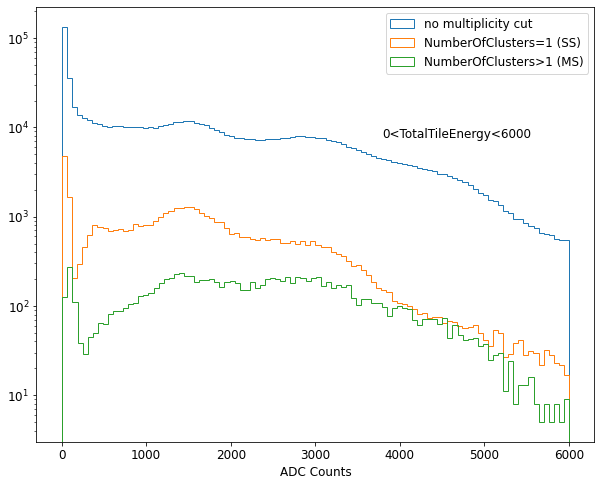

In [6]:
cut_array = ['TotalTileEnergy>0', 'TotalTileEnergy<6000','NumberOfClusters==1']
cut_array1 = cut_array[:2]
cut_array2 = cut_array[:2] + ['NumberOfClusters>1']
cut = Cut(cut_array,df,derived_dict)
cut1 = Cut(cut_array1,df,derived_dict)
cut2 = Cut(cut_array2,df,derived_dict)
mask = cut.mask
mask = np.logical_and(mask,df['IsFull3D'])
mask1 = cut1.mask
mask2 = cut2.mask
mask2 = np.logical_and(mask2,df['IsFull3D'])
plt.hist(df['TotalTileEnergy'].loc[mask1],bins=bins,histtype='step',\
                                 label='no multiplicity cut',log=True)
plt.hist(df['TotalTileEnergy'].loc[mask],bins=bins,histtype='step',\
                                 label=cut.GetString().split(',')[0] + ' (SS)',log=True)
plt.hist(df['TotalTileEnergy'].loc[mask2],bins=bins,histtype='step',\
                                 label=cut2.GetString().split(',')[0] + ' (MS)',log=True)
plt.text(0.62, 0.7, cut1.GetString('\n'), transform = plt.gca().transAxes)
plt.xlabel('ADC Counts')
plt.legend()

Above it is possible to see the comparision of the total spectrum with the SS/MS. The 570keV peak is mainly SS, while the 1064keV is more MS than SS

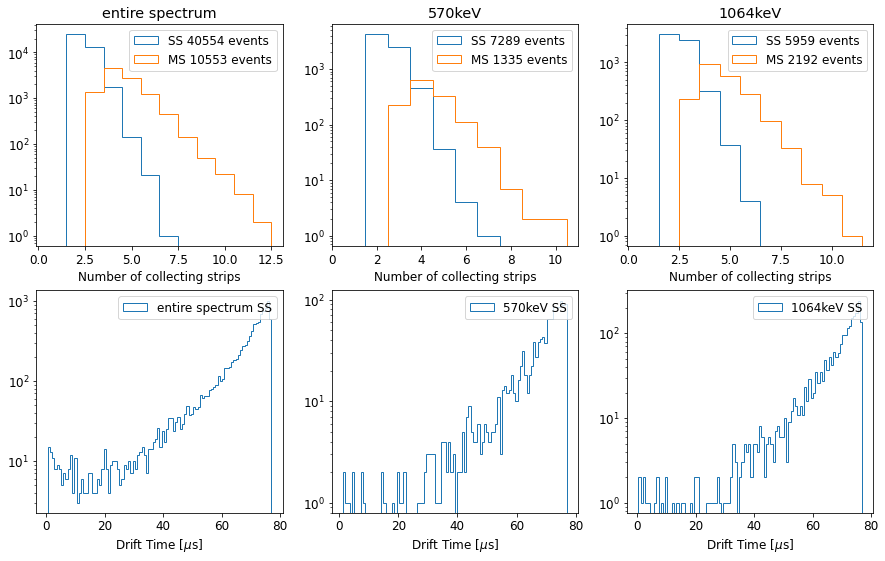

In [7]:
fig, ax = plt.subplots(2,3, figsize=(15,9))
limits = [['150','6000'],['1100','1500'],['2300','3000']]
labels = ['entire spectrum','570keV','1064keV']
cut_array = ['DriftTime>0', 'DriftTime<77']
last = False
legend = 'SS'
for cut_string in [['NumberOfClusters==1'],['NumberOfClusters>1']]:
    cut_array = cut_array[:2] + cut_string
    if last:
        legend = 'MS'
    for i in range(3):
            cut_array = cut_array[:3] +\
            ['TotalTileEnergy>{}'.format(limits[i][0]), 'TotalTileEnergy<{}'.format(limits[i][1])]
            cut = Cut(cut_array,df,derived_dict)
            mask = cut.mask
            mask = np.logical_and(mask,df['IsFull3D'])
            bin_limits = np.arange(max(df['NumTileChannelsHit'].loc[mask])+1) + 0.5
            ax[0,i].hist(df['NumTileChannelsHit'].loc[mask],bins=bin_limits,histtype='step',log=True,\
                         label=legend + ' {} events'.format(sum(mask)))
            ax[0,i].set_xlabel('Number of collecting strips')
            ax[0,i].set_title(labels[i])
            ax[0,i].legend()
            if last:
                ax[1,i].hist(DriftTime.loc[mask],bins=bins,histtype='step',log=True,label=labels[i] + ' SS')
                ax[1,i].set_xlabel('Drift Time [$\mu$s]')
                ax[1,i].legend()
    last = True

in the upper row of histograms I compare the SS/MS distribution of the number of strips that collected a signal in three different energy ranges, as expected the SS histograms peak earlier with just 2 strips as most probable value and falls more rapidly, than for the MS case. It is worth mentioning that the two 10 bundled channels are included here, so not a lot can be inferred on the size of the clusters. Lower row is the time distribution of the SS events

## SS Analysis

Text(0.5, 1.0, 'SS strips count')

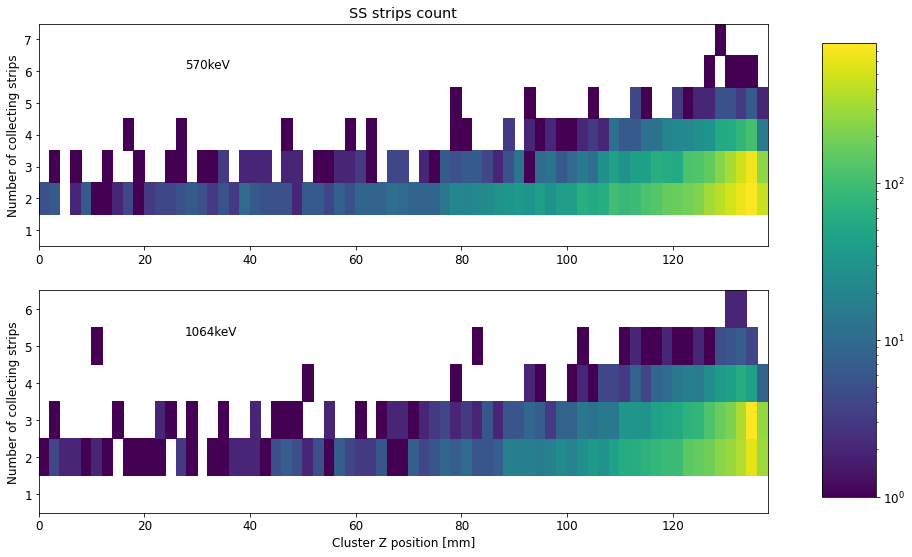

In [8]:
fig, ax = plt.subplots(2, figsize=(15,9))
limits = [['1100','1500'],['2300','3000']]
labels = ['570keV','1064keV']
cut_array = ['DriftTime>0', 'DriftTime<77','NumberOfClusters==1']
last = False
ax_text = '570keV'
for i in range(2):
    cut_array = cut_array[:3] +\
    ['TotalTileEnergy>{}'.format(limits[i][0]), 'TotalTileEnergy<{}'.format(limits[i][1])]
    cut = Cut(cut_array,df,derived_dict)
    mask = cut.mask
    mask = np.logical_and(mask,df['IsFull3D'])
    bin_limits_x = np.arange(0,140,2)
    bin_limits_y = np.arange(max(df['NumTileChannelsHit'].loc[mask])+1) + 0.5
    _,_,_,im = ax[i].hist2d(df['Cluster Z-Pos'][mask].map(lambda x: x[0]),df['NumTileChannelsHit'][mask],\
                 bins=[bin_limits_x,bin_limits_y], norm=LogNorm())
    ax[i].set_ylabel('Number of collecting strips')
    if last:
        ax_text = '1064keV'
    ax[i].text(0.2, 0.8, ax_text, transform = ax[i].transAxes)
    last = True

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax)
ax[1].set_xlabel('Cluster Z position [mm]')
ax[0].set_title('SS strips count')

for SS events only, I look into how the number of collecting strips are distributed along z. The idea is to look if there is a correlation between this two quantities to monitor the tranversal diffusion, still most of the distribution is skewed towards the big bundles

Text(0.5, 1.0, 'SS strips count - Bundled channels removed')

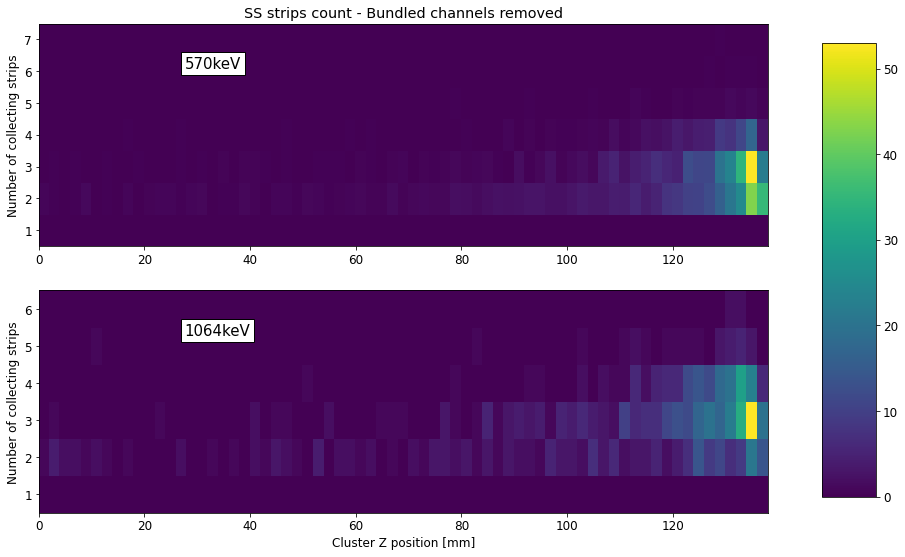

In [9]:
fig, ax = plt.subplots(2, figsize=(15,9))
limits = [['1100','1500'],['2300','3000']]
labels = ['570keV','1064keV']
cut_array = ['DriftTime>0', 'DriftTime<77','NumberOfClusters==1',\
             'TileStrip X1-12 Charge Energy==0','TileStrip Y1-10 Charge Energy==0']
last = False
ax_text = '570keV'
for i in range(2):
    cut_array = cut_array[:5] +\
    ['TotalTileEnergy>{}'.format(limits[i][0]), 'TotalTileEnergy<{}'.format(limits[i][1])]
    cut = Cut(cut_array,df,derived_dict)
    mask = cut.mask
    mask = np.logical_and(mask,df['IsFull3D'])
    bin_limits_x = np.arange(0,140,2)
    bin_limits_y = np.arange(max(df['NumTileChannelsHit'].loc[mask])+1) + 0.5
    _,_,_,im = ax[i].hist2d(df['Cluster Z-Pos'][mask].map(lambda x: x[0]),df['NumTileChannelsHit'][mask],\
                 bins=[bin_limits_x,bin_limits_y])
    ax[i].set_ylabel('Number of collecting strips')
    if last:
        ax_text = '1064keV'
    ax[i].text(0.2, 0.8, ax_text, bbox=dict(facecolor='white'), fontsize=15, transform = ax[i].transAxes)
    last = True

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax)
ax[1].set_xlabel('Cluster Z position [mm]')
ax[0].set_title('SS strips count - Bundled channels removed')

here the big bundles are removed. It is possible to see how the distribution slightly shifts upwards, most of the SS clusters are 2 strips or more possibly due to diffusion. The 1064keV events seem to be mildy larger clusters than the 570keV. Maybe due to continuous channel Compton reconstructed as one cluster?

Text(0.5, 0, 'event RMS size [mm]')

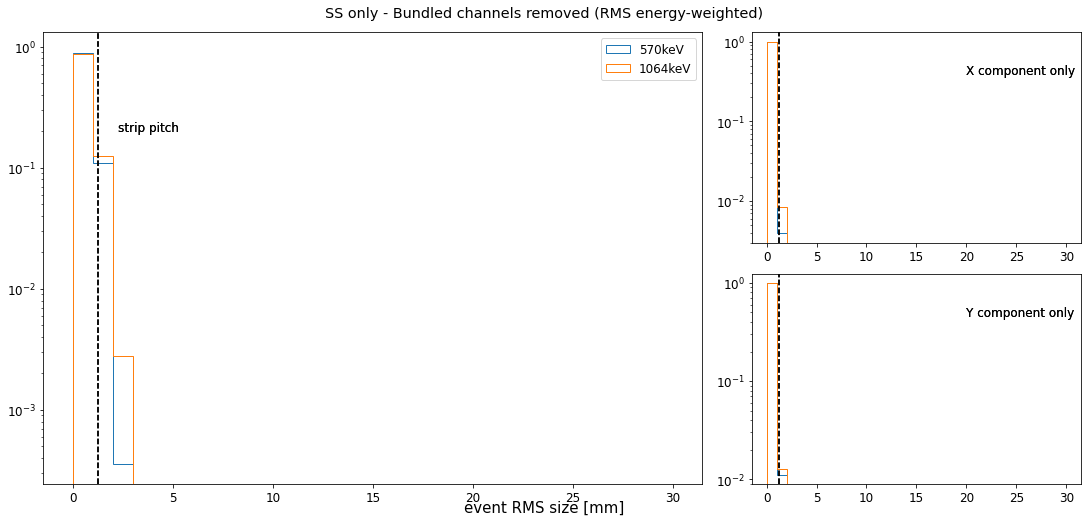

In [10]:
strip_rms = 3/np.sqrt(6)
fig3 = plt.figure(constrained_layout=True,figsize=(15,7))
gs = fig3.add_gridspec(2, 3)
f3_ax0 = fig3.add_subplot(gs[:, :-1])
f3_ax1 = fig3.add_subplot(gs[0, -1])
f3_ax2 = fig3.add_subplot(gs[1, -1])
limits = [['1100','1500'],['2300','3000']]
labels = ['570keV','1064keV']
cut_array = ['DriftTime>0', 'DriftTime<77','NumberOfClusters==1',\
             'TileStrip X1-12 Charge Energy==0','TileStrip Y1-10 Charge Energy==0']
last = False
ax_text = '570keV'
array_bin = np.arange(0,31)
for i in range(2):
    if last:
        ax_text = '1064keV'
    cut_array = cut_array[:5] +\
    ['TotalTileEnergy>{}'.format(limits[i][0]), 'TotalTileEnergy<{}'.format(limits[i][1])]
    cut = Cut(cut_array,df,derived_dict)
    mask = cut.mask
    mask = np.logical_and(mask,df['IsFull3D'])
    cluster_size = np.hypot(df['Weighted Event Size X'][mask],\
                            np.hypot(df['Weighted Event Size Y'][mask],df['Weighted Event Size Z'][mask]))
    f3_ax0.hist(cluster_size,bins=array_bin,label=labels[i],histtype='step',density=True, log=True)
    f3_ax0.axvline(x=strip_rms,linestyle='--',c='black')
    f3_ax0.text(strip_rms+1, 0.2, 'strip pitch', fontsize=12)
    f3_ax1.hist(df['Weighted Event Size X'][mask],\
                bins=array_bin,label=labels[i],histtype='step',density=True, log=True)
    
    f3_ax1.text(0.65, 0.8, 'X component only', fontsize=12, transform = f3_ax1.transAxes)
    f3_ax1.axvline(x=strip_rms,linestyle='--',c='black')
    f3_ax2.hist(df['Weighted Event Size Y'][mask],\
                bins=array_bin,label=labels[i],histtype='step',density=True, log=True)
    f3_ax2.text(0.65, 0.8, 'Y component only', fontsize=12, transform = f3_ax2.transAxes)
    f3_ax2.axvline(x=strip_rms,linestyle='--',c='black')
    last = True

f3_ax0.legend()
fig3.suptitle('SS only - Bundled channels removed (RMS energy-weighted)')
fig3.text(0.5, 0,'event RMS size [mm]', ha='center', va='center',fontsize=15)

The transversal RMS of the cluster is shown here. This is weighted by the energy, showing how in all the SS events the charge is mostly collected by less than 3 strips

Text(0.5, 0, 'event size [mm]')

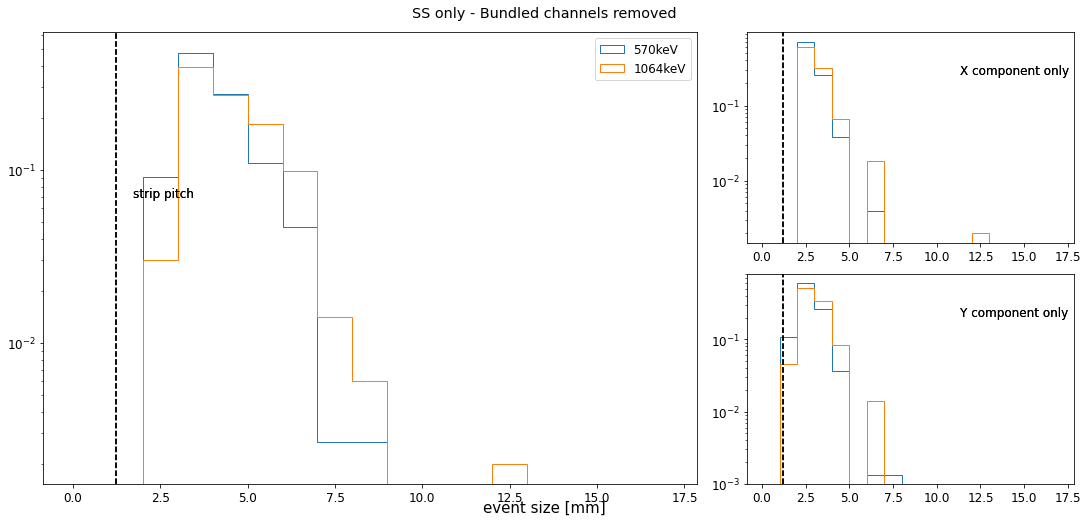

In [11]:
fig3 = plt.figure(constrained_layout=True,figsize=(15,7))
gs = fig3.add_gridspec(2, 3)
f3_ax0 = fig3.add_subplot(gs[:, :-1])
f3_ax1 = fig3.add_subplot(gs[0, -1])
f3_ax2 = fig3.add_subplot(gs[1, -1])
limits = [['1100','1500'],['2300','3000']]
labels = ['570keV','1064keV']
cut_array = ['DriftTime>0', 'DriftTime<77','NumberOfClusters>1',\
             'TileStrip X1-12 Charge Energy==0','TileStrip Y1-10 Charge Energy==0']
last = False
ax_text = '570keV'
array_bin = np.arange(0,18,1)
for i in range(2):
    if last:
        ax_text = '1064keV'
    cut_array = cut_array[:5] +\
    ['TotalTileEnergy>{}'.format(limits[i][0]), 'TotalTileEnergy<{}'.format(limits[i][1])]
    cut = Cut(cut_array,df,derived_dict)
    mask = cut.mask
    mask = np.logical_and(mask,df['IsFull3D'])
    cluster_size = np.hypot(df['NumXTileChannelsHit'][mask]*strip_rms,df['NumYTileChannelsHit'][mask]*strip_rms)
    f3_ax0.hist(cluster_size,bins=array_bin,label=labels[i],histtype='step',density=True, log=True)
    f3_ax0.axvline(x=strip_rms,linestyle='--',c='black')
    f3_ax0.text(strip_rms+0.5, 0.07, 'strip pitch', fontsize=12)
    f3_ax1.hist(df['NumXTileChannelsHit'][mask]*strip_rms,\
                bins=array_bin,label=labels[i],histtype='step',density=True, log=True)
    f3_ax1.text(0.65, 0.8, 'X component only', fontsize=12, transform = f3_ax1.transAxes)
    f3_ax1.axvline(x=strip_rms,linestyle='--',c='black')
    f3_ax2.hist(df['NumYTileChannelsHit'][mask]*strip_rms,\
                bins=array_bin,label=labels[i],histtype='step',density=True, log=True)
    f3_ax2.text(0.65, 0.8, 'Y component only', fontsize=12, transform = f3_ax2.transAxes)
    f3_ax2.axvline(x=strip_rms,linestyle='--',c='black')
    last = True

f3_ax0.legend()
fig3.suptitle('SS only - Bundled channels removed')
fig3.text(0.5, 0,'event size [mm]', ha='center', va='center',fontsize=15)

Plotted here is the real size of the event not weighted by the energy. Together with the previous plots, it is possible to see how some charge always leaks in the neighboring strips. Note that there is no z-cut, for the low statistics away from the cathode

## MS Analysis - work in progress

Text(0.5, 1.0, 'MS strips count - Bundled channels removed')

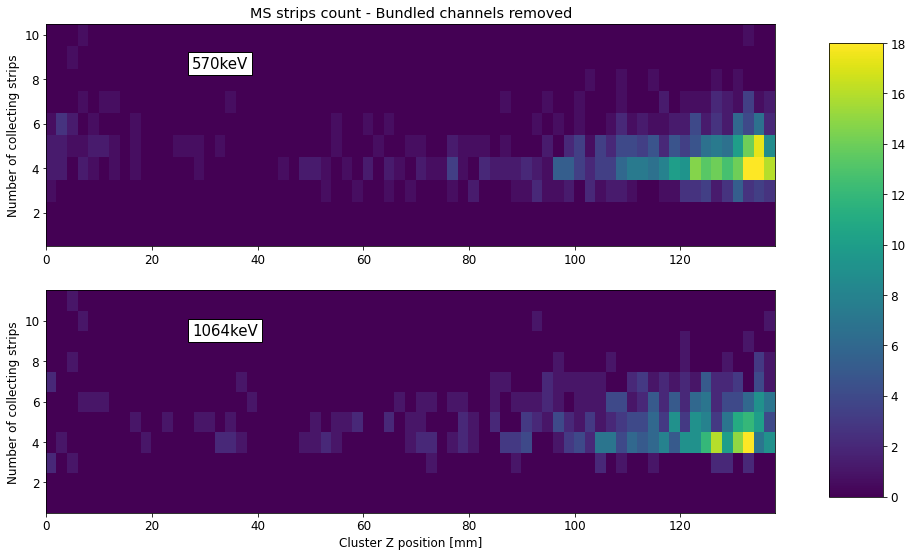

In [12]:
fig, ax = plt.subplots(2, figsize=(15,9))
limits = [['1100','1500'],['2300','3000']]
labels = ['570keV','1064keV']
cut_array = ['DriftTime>0', 'DriftTime<77','NumberOfClusters>1',\
             'TileStrip X1-12 Charge Energy==0','TileStrip Y1-10 Charge Energy==0']
last = False
ax_text = '570keV'
for i in range(2):
    cut_array = cut_array[:5] +\
    ['TotalTileEnergy>{}'.format(limits[i][0]), 'TotalTileEnergy<{}'.format(limits[i][1])]
    cut = Cut(cut_array,df,derived_dict)
    mask = cut.mask
    mask = np.logical_and(mask,df['IsFull3D'])
    bin_limits_x = np.arange(0,140,2)
    bin_limits_y = np.arange(max(df['NumTileChannelsHit'].loc[mask])+1) + 0.5
    _,_,_,im = ax[i].hist2d(df['Cluster Z-Pos'][mask].map(lambda x: x[0]),df['NumTileChannelsHit'][mask],\
                 bins=[bin_limits_x,bin_limits_y])
    ax[i].set_ylabel('Number of collecting strips')
    if last:
        ax_text = '1064keV'
    ax[i].text(0.2, 0.8, ax_text, bbox=dict(facecolor='white'), fontsize=15, transform = ax[i].transAxes)
    last = True

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax)
ax[1].set_xlabel('Cluster Z position [mm]')
ax[0].set_title('MS strips count - Bundled channels removed')

For the MS events as expected the events are bigger and as more strips are involved

Text(0.5, 0, 'event RMS size [mm]')

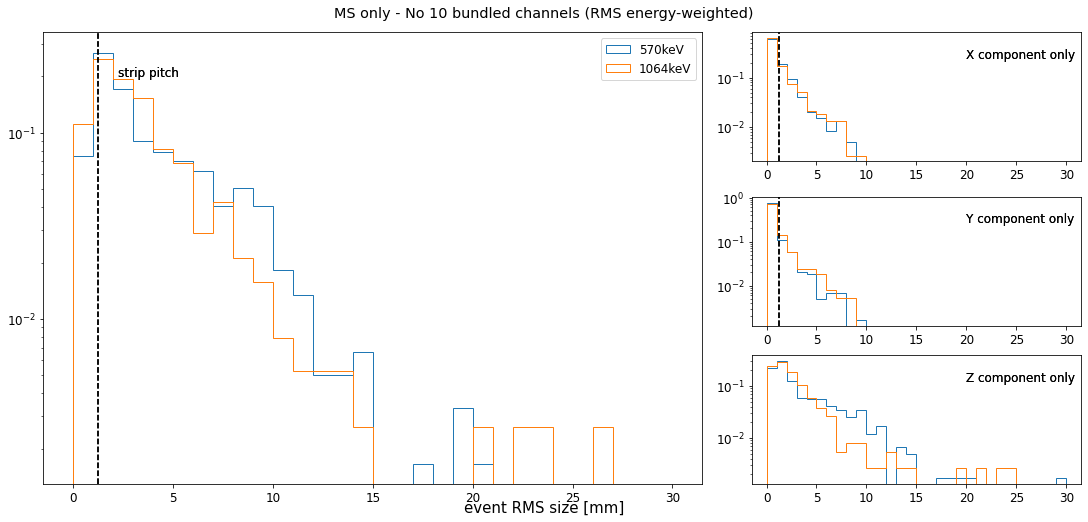

In [13]:
fig3 = plt.figure(constrained_layout=True,figsize=(15,7))
gs = fig3.add_gridspec(3, 3)
f3_ax0 = fig3.add_subplot(gs[:, :-1])
f3_ax1 = fig3.add_subplot(gs[0, -1])
f3_ax2 = fig3.add_subplot(gs[1, -1])
f3_ax3 = fig3.add_subplot(gs[2, -1])
limits = [['1100','1500'],['2300','3000']]
labels = ['570keV','1064keV']
cut_array = ['DriftTime>60', 'DriftTime<77','NumberOfClusters>1',\
             'TileStrip X1-12 Charge Energy==0','TileStrip Y1-10 Charge Energy==0']
last = False
ax_text = '570keV'
array_bin = np.arange(0,31)
for i in range(2):
    if last:
        ax_text = '1064keV'
    cut_array = cut_array[:5] +\
    ['TotalTileEnergy>{}'.format(limits[i][0]), 'TotalTileEnergy<{}'.format(limits[i][1])]
    cut = Cut(cut_array,df,derived_dict)
    mask = cut.mask
    mask = np.logical_and(mask,df['IsFull3D'])
    cluster_size = np.hypot(df['Weighted Event Size X'][mask],\
                            np.hypot(df['Weighted Event Size Y'][mask],df['Weighted Event Size Z'][mask]))
    f3_ax0.hist(cluster_size,bins=array_bin,label=labels[i],histtype='step',density=True, log=True)
    f3_ax0.axvline(x=strip_rms,linestyle='--',c='black')
    f3_ax0.text(strip_rms + 1, 0.2, 'strip pitch', fontsize=12)
    f3_ax1.hist(df['Weighted Event Size X'][mask],\
                bins=array_bin,label=labels[i],histtype='step',density=True, log=True)
    
    f3_ax1.text(0.65, 0.8, 'X component only', fontsize=12, transform = f3_ax1.transAxes)
    f3_ax1.axvline(x=strip_rms,linestyle='--',c='black')
    f3_ax2.hist(df['Weighted Event Size Y'][mask],\
                bins=array_bin,label=labels[i],histtype='step',density=True, log=True)
    f3_ax2.text(0.65, 0.8, 'Y component only', fontsize=12, transform = f3_ax2.transAxes)
    f3_ax2.axvline(x=strip_rms,linestyle='--',c='black')
    f3_ax3.hist(df['Weighted Event Size Z'][mask],\
                bins=array_bin,label=labels[i],histtype='step',density=True, log=True)
    f3_ax3.text(0.65, 0.8, 'Z component only', fontsize=12, transform = f3_ax3.transAxes)
    last = True

f3_ax0.legend()
fig3.suptitle('MS only - No 10 bundled channels (RMS energy-weighted)')
fig3.text(0.5, 0,'event RMS size [mm]', ha='center', va='center',fontsize=15)

this histogram shows the RMS size of the MS events (the 10 strips bundled channels are removed). The x and y component have a sharp cutoff mostly due to the physical size of the tile. Most of the energy is deposited in one interaction or more with distance less than ~3mm. The z component is not binned in 3mm steps (pitch of the tile) so it's possible to see sub-3mm structure. The z component shows a population of event with bigger size, these are possibly early early low energy Compton before depositing the remaing. No real difference between the 570 and the 1064 peaks

In [21]:
from TMSAnalysis.WaveformAnalysis.Waveform import Event

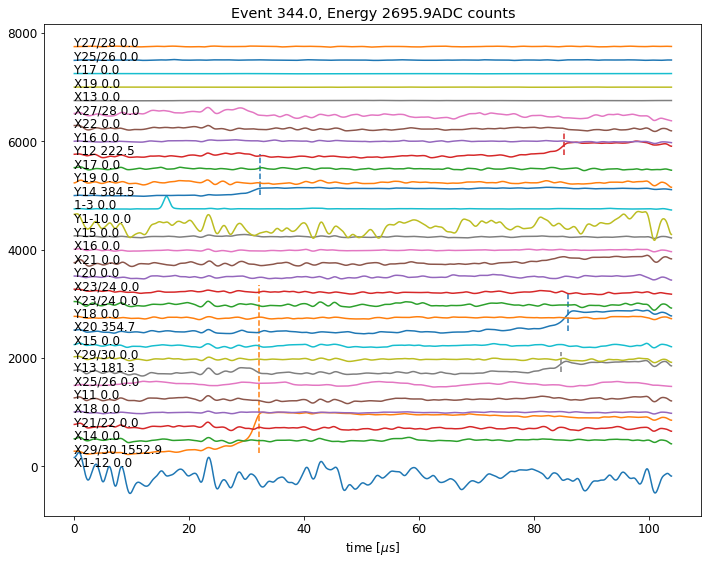

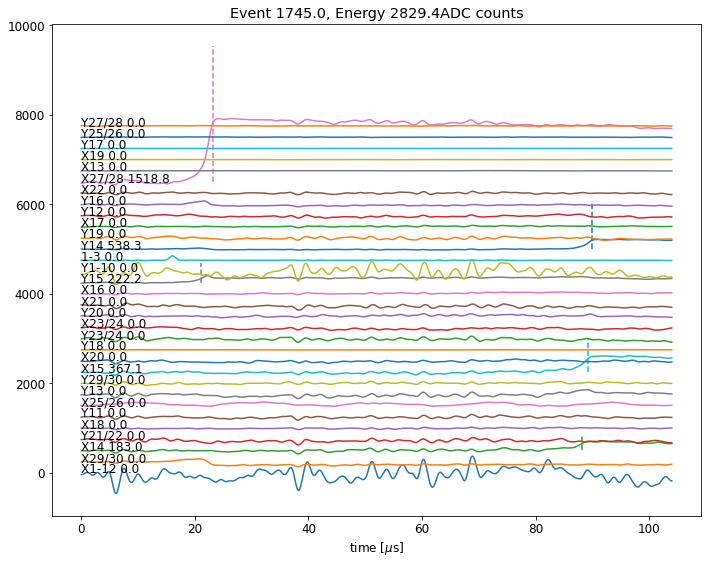

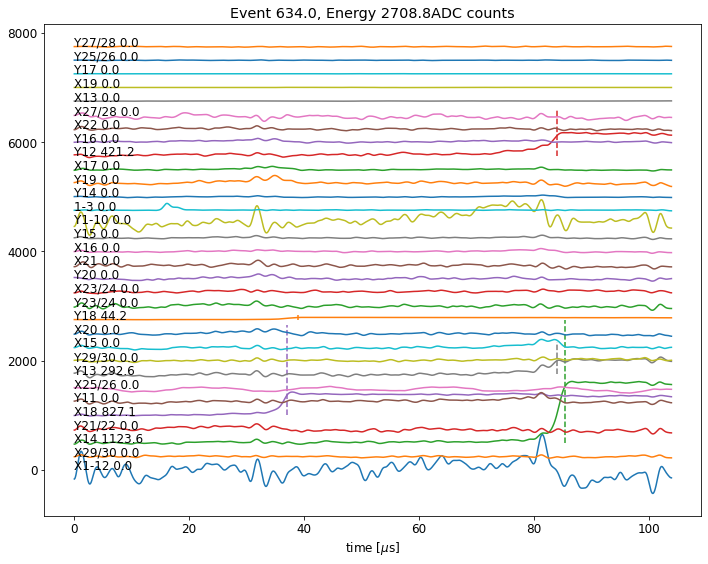

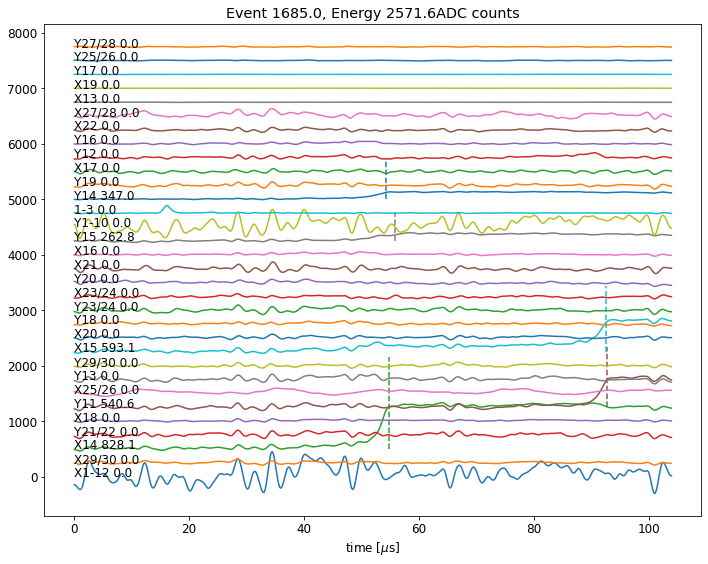

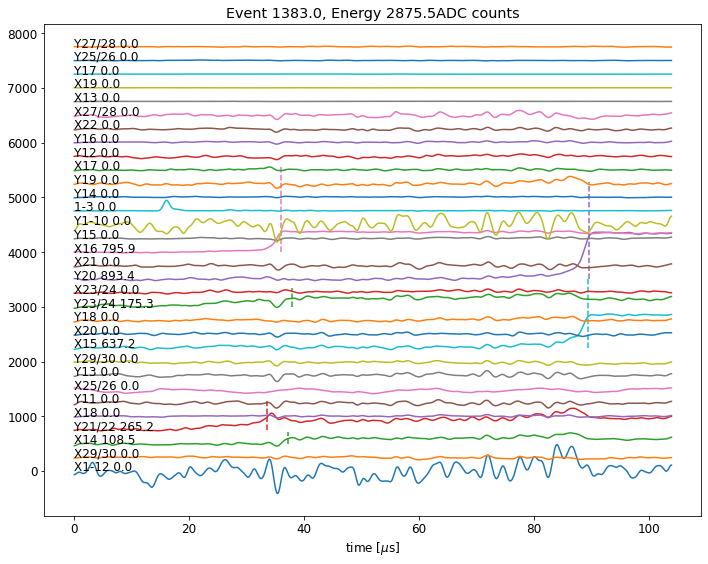

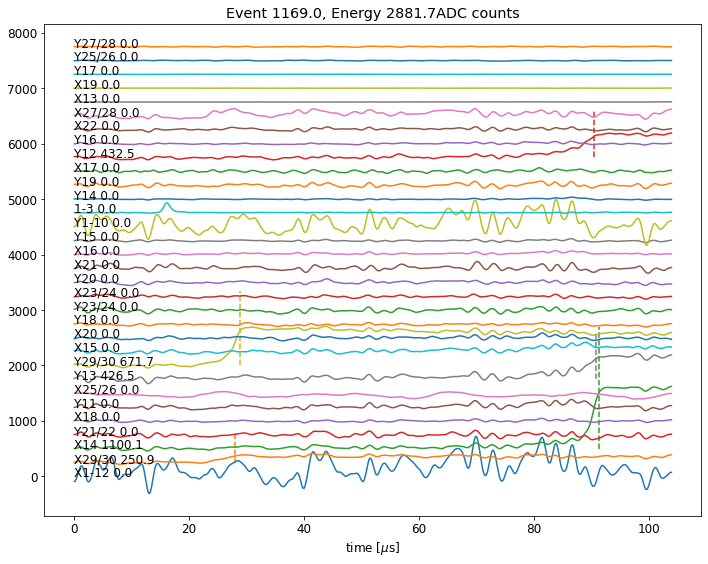

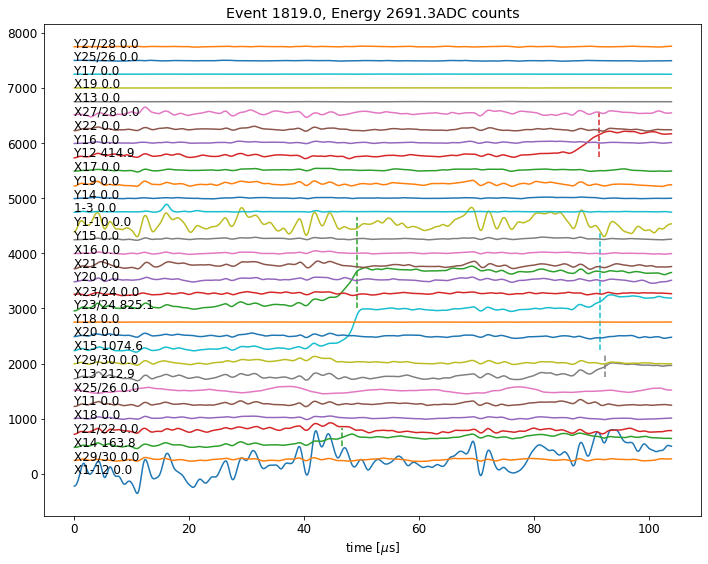

In [25]:
event_list = np.where(np.logical_and(mask,df['Weighted Event Size Z']>16))[0]
for ev in event_list:
    event = Event('/p/lustre1/jacopod/29th/analysis/20200212_RecirculationOff/reduced_added.h5',\
             '/p/lustre1/jacopod/29th/20200212_RecirculationOff/tier1/',\
             ev,\
             '/g/g90/jacopod/software/TMSAnalysis/config/Run_Parameters_Xe_Run29.csv',\
             '/g/g90/jacopod/software/TMSAnalysis/config/Calibrations_Xe_Run11b.csv',\
             '/g/g90/jacopod/software/TMSAnalysis/config/Channel_Map_Xe_Run29.csv')
    event.smooth(0.5)
    plot = event.plot_event(risetime=True)
    plot.show()

In [26]:
it is possible to see the two separated cluster in time, clear Compton or coincidence (event 634?)

SyntaxError: invalid syntax (<ipython-input-26-2c9aaf1424cb>, line 1)

Text(0.5, 0, 'event RMS size [mm]')

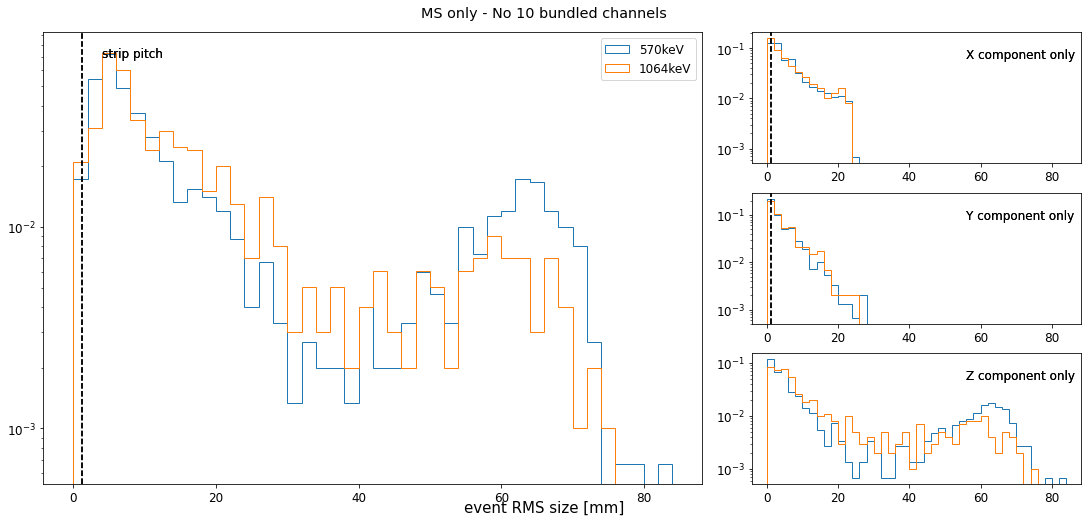

In [14]:
fig3 = plt.figure(constrained_layout=True,figsize=(15,7))
gs = fig3.add_gridspec(3, 3)
f3_ax0 = fig3.add_subplot(gs[:, :-1])
f3_ax1 = fig3.add_subplot(gs[0, -1])
f3_ax2 = fig3.add_subplot(gs[1, -1])
f3_ax3 = fig3.add_subplot(gs[2, -1])
limits = [['1100','1500'],['2300','3000']]
labels = ['570keV','1064keV']
cut_array = ['DriftTime>0', 'DriftTime<77','NumberOfClusters>1',\
             'TileStrip X1-12 Charge Energy==0','TileStrip Y1-10 Charge Energy==0']
last = False
ax_text = '570keV'
array_bin = np.arange(0,85,2)
for i in range(2):
    if last:
        ax_text = '1064keV'
    cut_array = cut_array[:5] +\
    ['TotalTileEnergy>{}'.format(limits[i][0]), 'TotalTileEnergy<{}'.format(limits[i][1])]
    cut = Cut(cut_array,df,derived_dict)
    mask = cut.mask
    mask = np.logical_and(mask,df['IsFull3D'])
    cluster_size = np.hypot([np.std(c) for c in df['Cluster X-Pos'][mask]],\
                            np.hypot([np.std(c) for c in df['Cluster Y-Pos'][mask]],\
                                     [np.std(c) for c in df['Cluster Z-Pos'][mask]]))
    f3_ax0.hist(cluster_size,bins=array_bin,label=labels[i],histtype='step',density=True, log=True)
    f3_ax0.axvline(x=strip_rms,linestyle='--',c='black')
    f3_ax0.text(4, 0.07, 'strip pitch', fontsize=12)
    f3_ax1.hist([np.std(c) for c in df['Cluster X-Pos'][mask]],\
                bins=array_bin,label=labels[i],histtype='step',density=True, log=True)
    f3_ax1.text(0.65, 0.8, 'X component only', fontsize=12, transform = f3_ax1.transAxes)
    f3_ax1.axvline(x=strip_rms,linestyle='--',c='black')
    f3_ax2.hist([np.std(c) for c in df['Cluster Y-Pos'][mask]],\
                bins=array_bin,label=labels[i],histtype='step',density=True, log=True)
    f3_ax2.text(0.65, 0.8, 'Y component only', fontsize=12, transform = f3_ax2.transAxes)
    f3_ax2.axvline(x=strip_rms,linestyle='--',c='black')
    f3_ax3.hist([np.std(c) for c in df['Cluster Z-Pos'][mask]],\
                bins=array_bin,label=labels[i],histtype='step',density=True, log=True)
    f3_ax3.text(0.65, 0.8, 'Z component only', fontsize=12, transform = f3_ax3.transAxes)
    last = True

f3_ax0.legend()
fig3.suptitle('MS only - No 10 bundled channels')
fig3.text(0.5, 0,'event RMS size [mm]', ha='center', va='center',fontsize=15)

this histogram shows the RMS size of the MS events (the 10 strips bundled channels are removed) not weighted for the energy. Also in ths case the x and y component have the sharp cutoff. The peak around 60mm is an artifact due to some extremely low pickup from the baseline